In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import datetime

pylab.rcParams['figure.figsize'] = 16, 8
pylab.rcParams['font.size'] = 16

# Estimating subway passenger exit counts through emergency exits using sound.

Matt Dwyer

Urban Sensing 2018

## 1. Load Audio Sample

In [2]:
# load recording from mic above door
fs, samples = wavfile.read('01.wav')

In [3]:
dur = float(len(samples)) / fs
sample_len = len(samples)

print ('Sample rate: ', fs, 'Hz')
print ('Length in samples: ', sample_len)
print ('Length in seconds: ', '%.3f' % dur)
print ('Sample data type: ', samples.dtype)

Sample rate:  48000 Hz
Length in samples:  75098112
Length in seconds:  1564.544
Sample data type:  int16


In [4]:
# The sample data is in the form of 16 bit integers so convert to floats
samples = samples / 32768.0

In [5]:
T = np.linspace(0, dur, num=sample_len)

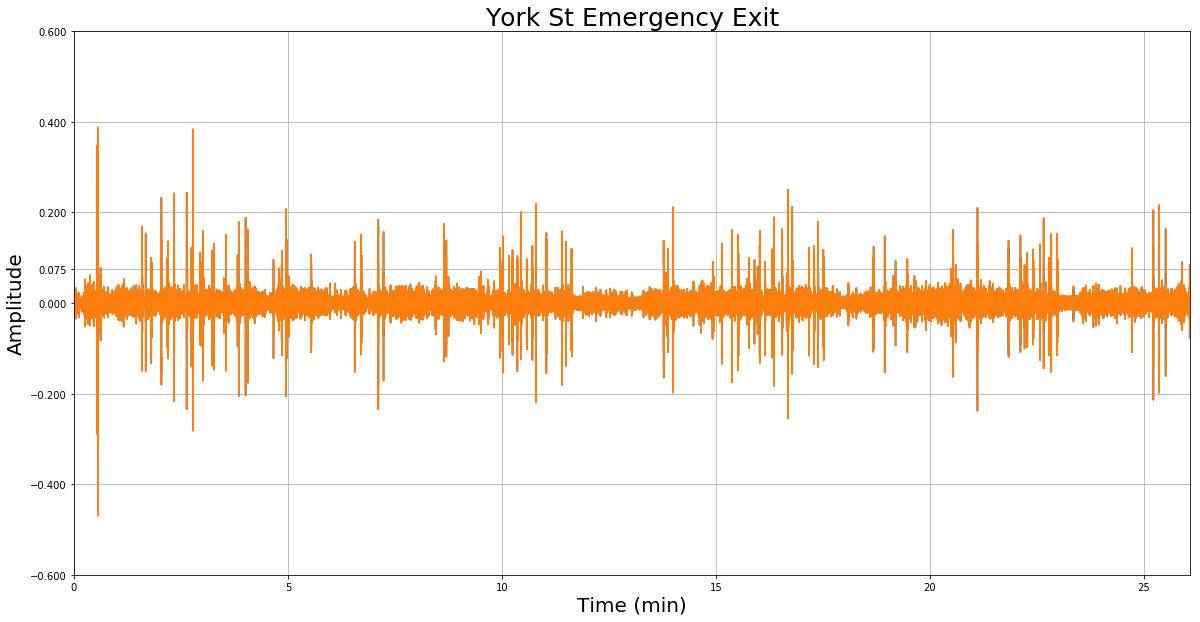

In [14]:
plt.figure(figsize=(20,10))
plt.plot(T/60, samples)
plt.ylim([-.5, .5])
plt.xlim([0, np.max(T/60)])
plt.yticks(list(plt.yticks()[0]) + [0.075])
plt.title('York St Emergency Exit',fontsize=25)
plt.xlabel('Time (min)',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.grid()

### Figure 1. Peaks in amplitude represent sound from the door opening or closing. A threshold of 0.075 is chosen as a conservative measure to identify each peak.

In [223]:
df = pd.DataFrame({'Time':T/60,'Amplitude':[x[1] for x in samples.tolist()]})

## 2. Identify times when threshold is crossed

In [224]:
# create column to identify where threshold is crossed
df['Threshold_bool'] = np.where(df['Amplitude'] > .075,1,0)

# reduce dataframe to where treshold level changes
df['Threshold_change'] = df['Threshold_bool'].diff()
df = df[df['Threshold_change'] != 0]

In [225]:
# remove times not within 0.01 minutes of each other
df = df[df['Time'].diff() > 0.01]

# convert to datetime
df['Time'] = list(map(str, [datetime.timedelta(minutes=x) for x in df['Time']]))
df['Time'] = pd.to_datetime(df['Time'])

In [226]:
df.head()

,Amplitude,Time,Threshold_bool,Threshold_change
1532788,0.099426,2018-04-26 00:00:31.933084,1,1.0
1617028,0.076324,2018-04-26 00:00:33.688084,1,1.0
1791989,0.078033,2018-04-26 00:00:37.333105,1,1.0
4567734,0.091827,2018-04-26 00:01:35.161126,1,1.0
4824563,0.076904,2018-04-26 00:01:40.511731,1,1.0


#### Table 1. Each row is a peak when the threshold was crossed, showing when the door was opened or closed.

In [227]:
# calculate the length of time door was opened or closed
df['Time_diff'] = df['Time'] - df['Time'].shift()

In [228]:
df.head()

,Amplitude,Time,Threshold_bool,Threshold_change,Time_diff
1532788,0.099426,2018-04-26 00:00:31.933084,1,1.0,NaT
1617028,0.076324,2018-04-26 00:00:33.688084,1,1.0,00:00:01.755000
1791989,0.078033,2018-04-26 00:00:37.333105,1,1.0,00:00:03.645021
4567734,0.091827,2018-04-26 00:01:35.161126,1,1.0,00:00:57.828021
4824563,0.076904,2018-04-26 00:01:40.511731,1,1.0,00:00:05.350605


## 3. Estimate people counts when door is open

In [255]:
df['person_est'] = [t.total_seconds() for t in df.Time_diff]

# reduction factor, averaged from the assumptions of maximum people/sec is 1, and minimum/sec is .125
rf = 0.56
df['person_est'] = df['person_est'] * rf

# sum every other person estimate, selecting rows when door is open
df.iloc[1::2, :]['person_est'].sum()

345.97934280000015

### Run estimates for other processed csv's

In [293]:
rf = 0.82
estimate = pd.read_csv('08.csv')
estimate['Time_diff'] = estimate['Time_diff'].str[8:]
estimate['Time_diff'] = pd.to_timedelta(estimate['Time_diff'],errors='coerce')
estimate['person_est'] = [t.total_seconds() for t in estimate.Time_diff]
estimate['person_est'] = estimate['person_est'] * rf
estimate.iloc[1::2, :]['person_est'].sum()

48.33830546

In [285]:
estimate.head()

,Unnamed: 0,Amplitude,Time,Threshold_bool,Threshold_change,Time_diff,person_est
0,138253,0.078339,2018-04-25 00:00:02.880271,1,1.0,NaT,NaN
1,469037,0.078857,2018-04-25 00:00:09.771604,1,1.0,00:00:06.891333,5.650893
2,1126925,0.075592,2018-04-25 00:00:23.477604,1,1.0,00:00:13.706000,11.238920
3,5936570,0.079834,2018-04-25 00:02:03.678543,1,1.0,00:01:40.200939,82.164770
4,6593453,0.093811,2018-04-25 00:02:17.363606,1,1.0,00:00:13.685063,11.221752
